This notebook runs the event segmentation analyses.

## Import libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools as hyp
from os.path import join as opj
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Define functions

In [2]:
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

## Setting paths

In [2]:
datadir = '/mnt/data/processed/'
figdir = '/mnt/paper/figs/'

## Load data

In [3]:
video_model, recall_models = np.load(opj(datadir, 'models_t100_v50_r10.npy'), allow_pickle=True)

## Find optimal k for video model

In [4]:
nEvents = np.arange(2,51)
wd = np.zeros(len(nEvents))
corrmat = np.corrcoef(video_model)

for i, events in enumerate(nEvents):
    print(f'fitting with {events} events...', end='\r')
    ev = event.EventSegment(events)
    ev.fit(video_model)
    
    i1, i2 = np.where(np.round(ev.segments_[0])==1)
    w = np.zeros_like(ev.segments_[0])
    w[i1,i2] = 1
    mask = np.dot(w, w.T).astype(bool)

    # Create mask such that the maximum temporal distance for 
    # within and across correlations is the same
    local_mask = np.zeros(mask.shape, dtype=bool)
    for k in range(mask.shape[0]):
        if ~np.any(np.diag(mask, k)):
            break
        local_mask[np.diag(np.ones(local_mask.shape[0]-k, dtype=bool), k)] = True
    within_vals = np.reshape(corrmat[mask*local_mask], -1, 1) 
    across_vals = np.reshape(corrmat[~mask*local_mask], -1, 1)
    wd[i] = wasserstein_distance(within_vals, across_vals)

## Plot Wasserstein distance as a function of k

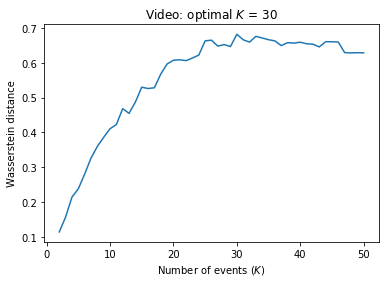

In [5]:
plt.plot(nEvents, wd)
maxk_video = nEvents[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Video: optimal $K$ = {maxk_video}')
plt.savefig(opj(figdir, 'k_optimization_video.pdf'), bbox_inches='tight')
plt.show()

## Fit event segmentation model to video

In [6]:
ev = event.EventSegment(maxk_video)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

## Save models

In [7]:
with open(opj(datadir, 'video_eventseg_model'), 'wb') as f:
    pickle.dump(ev, f)
np.save(opj(datadir, 'video_events'), video_events)

## Get video event times

In [8]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save(opj(datadir, 'video_event_times'), video_event_times)

## Fit event segmentation model to recall

In [9]:
ks = list(range(2, 51))
scores = []
for i, sub in enumerate(recall_models):
    mcorr = np.corrcoef(sub)
    cs = []
    for k in ks:
        print(f'\tfitting subject {i + 1} with {k} events...', end='\r')
        ev = event.EventSegment(k)
        ev.fit(sub)
        i1, i2 = np.where(np.round(ev.segments_[0])==1)
        w = np.zeros_like(ev.segments_[0])
        w[i1,i2] = 1
        mask = np.dot(w, w.T).astype(bool)
        
        # Create mask such that the maximum temporal distance for # within and across correlations is the same
        local_mask = np.zeros(mask.shape, dtype=bool)
        for m in range(mask.shape[0]):
            if ~np.any(np.diag(mask, m)):
                break
            local_mask[np.diag(np.ones(local_mask.shape[0]-m, dtype=bool), m)] = True
        within_vals = np.reshape(mcorr[mask*local_mask], -1, 1) 
        across_vals = np.reshape(mcorr[~mask*local_mask], -1, 1)
        cs.append(wasserstein_distance(within_vals, across_vals))
    scores.append(cs)

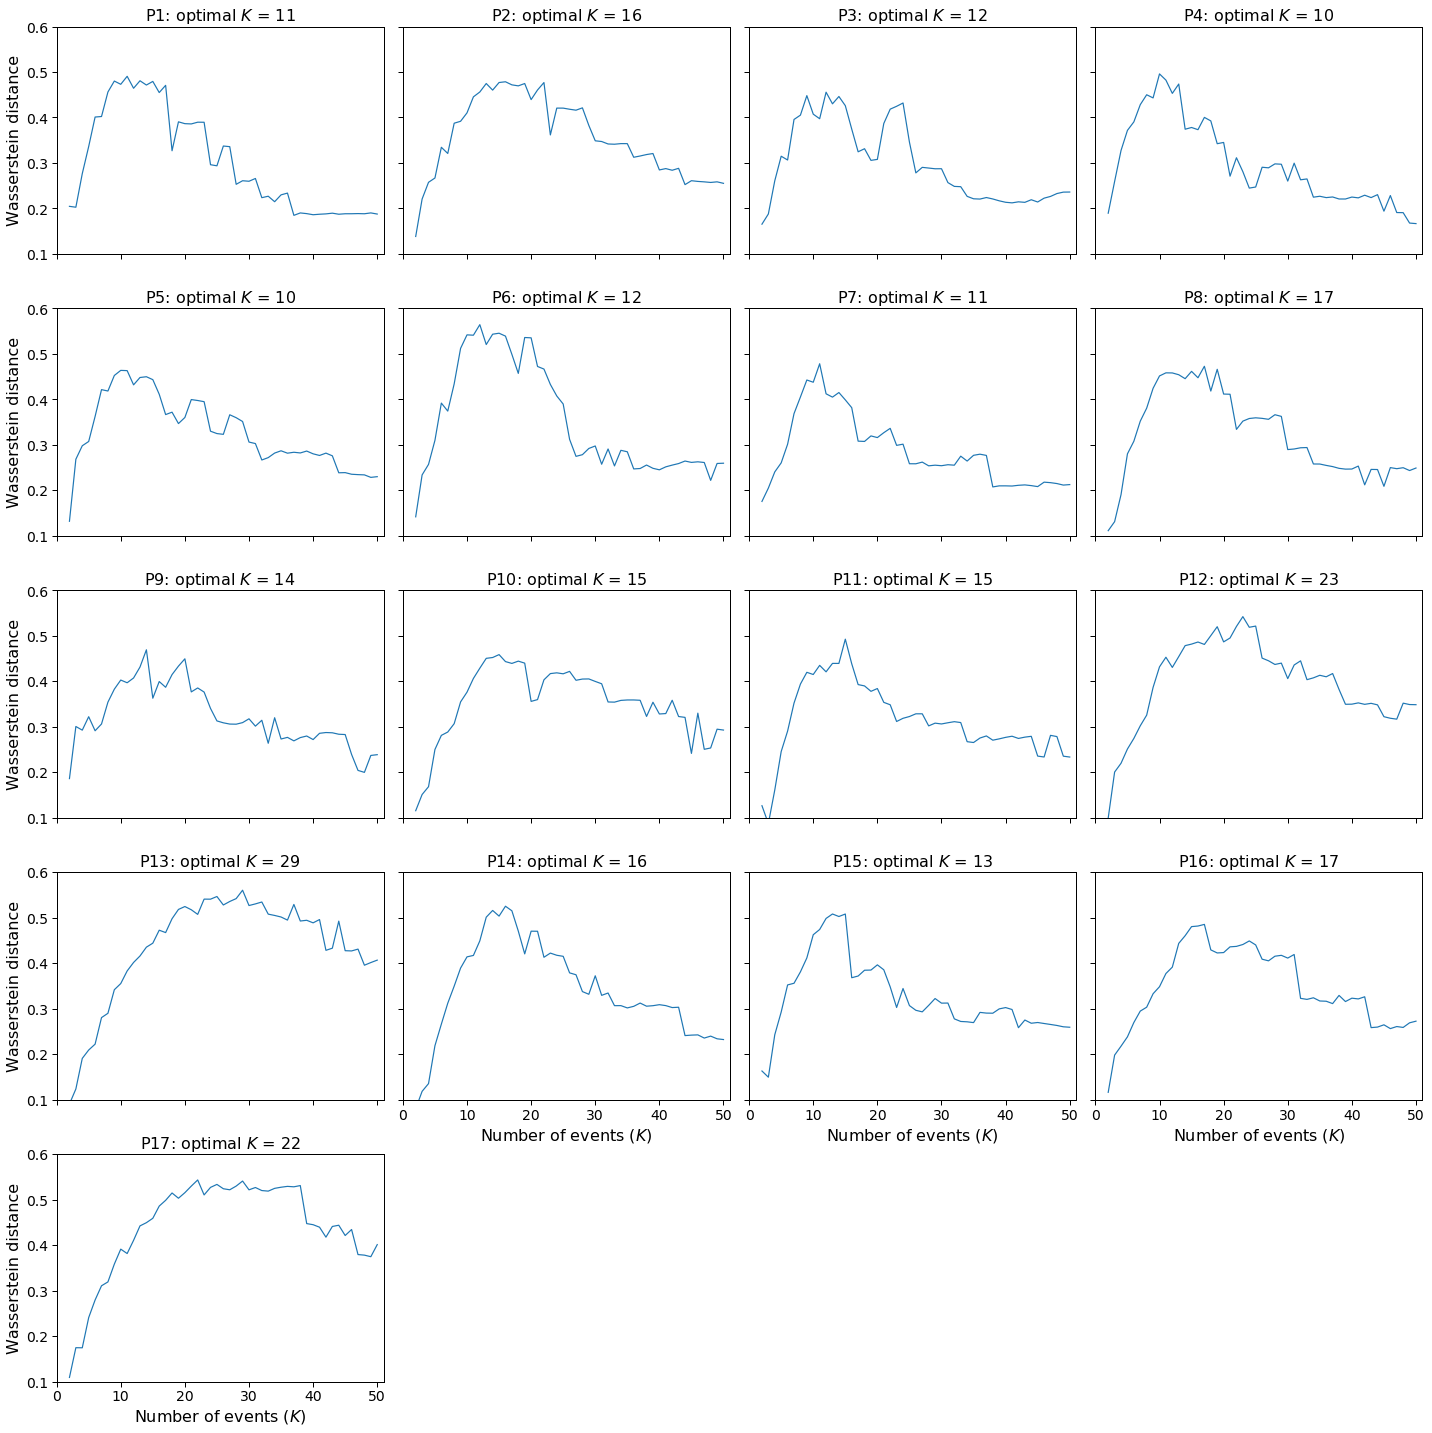

In [13]:
sns.set_context('paper')
fig, axarr = plt.subplots(nrows=5, ncols=4, sharey=True)
fig.set_size_inches(20,20)
axarr = axarr.flatten()

ks = list(range(2, 51))
maxk = []

for sub, cs in enumerate(scores):
    opt_k = ks[np.argmax(cs)]
    maxk.append(opt_k)
    
    axarr[sub].plot(ks, cs)
    axarr[sub].set_xticks(list(range(0, 51, 10)))
    axarr[sub].set_xlim(0, 51)
    axarr[sub].set_ylim(.1, .6)
    
    if not sub % 4:
        axarr[sub].set_ylabel('Wasserstein distance', fontsize=16)
        axarr[sub].tick_params(axis='y', labelsize=14)
    else:
        axarr[sub].set_ylabel('')

    if sub >= 13:
        axarr[sub].set_xlabel('Number of events ($K$)', fontsize=16)
        axarr[sub].tick_params(axis='x', labelsize=14)
    else:
        axarr[sub].set_xlabel('')
        axarr[sub].set_xticklabels([])
        
    axarr[sub].set_title(f'P{sub + 1}: optimal $K$ = {opt_k}', fontsize=16)
    
axarr[-3].axis('off')
axarr[-2].axis('off')
axarr[-1].axis('off')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig(opj(figdir, 'k_optimization_recall.pdf'), bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


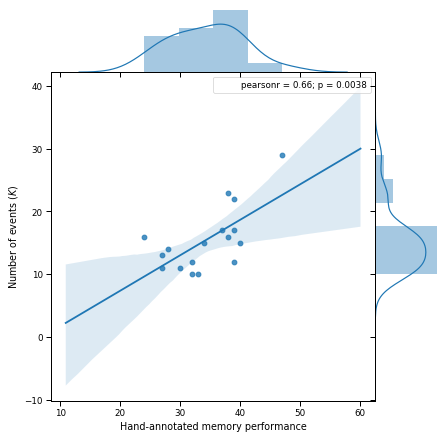

In [15]:
hand_rec = [27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39]
sns.jointplot(hand_rec, maxk, kind = 'reg', order = 1, space=0, stat_func=pearsonr)
plt.xlabel('Hand-annotated memory performance')
plt.ylabel('Number of events ($K$)')
plt.show()

## Fit model to recall using best k

In [16]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk):
    ev = event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)

## Create average recall model

In [17]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))

## Save models

In [26]:
np.save(opj(datadir, 'avg_recall_events'), avg_recall_events)
np.save(opj(datadir, 'labels'), matches)
np.save(opj(datadir, 'recall_events'), recall_events)
np.save(opj(datadir, 'recall_event_times'), recall_event_times)
with open(opj(datadir, 'recall_eventseg_models'), 'wb') as f:
    pickle.dump(recall_eventseg_models, f)